# Toronto Postal Codes

In this notebook we are going to cluster the dataset obtained in previous notebooks, where we unified: Postal Codes, Borough, Neighborhoods and the coordinates obtained from the postal code.

To make the clustering, we are going to add information about the restaurants near each postal code by its coordinates.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np
import folium
from geopy.geocoders import Nominatim

from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.cluster import KMeans

import requests

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Loading the dataset

In [2]:
df = pd.read_csv("Toronto_Postal_Geo.csv")

In [3]:
df.drop("Unnamed: 0", axis=1, inplace=True)

In [4]:
df_toronto = df[df['Borough'].str.contains('Toronto')]
df_toronto.reset_index(inplace=True, drop=True)

In [5]:
df_toronto.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M4E,East Toronto,The Beaches,43.676357,-79.293031


## Visualize Postal Codes markers

We are going to obtain a first visualization of the distribution of the different areas generated with the coordinates obtained from the postal codes.

In [6]:
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="toronto_ex")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

In [7]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=12, tiles="Stamen Terrain")

# add markers to map
for lat, lng, postal, neighborhood in zip(df_toronto['Latitude'], df_toronto['Longitude'], df_toronto['Postal Code'], df_toronto['Neighbourhood']):
    label = '{}, {}'.format(postal, neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

## Get the Category Venues from Foursquare

In order to obtain the features we need to perform the clustering, we are going to use the <b>Foursquare API</b>.

This API will give us information about the venues that are around the coordinates that we have obtained in the previous notebook.

For this work, we are going to filter the raw data to obtain the total number of restaurants found in each area.

- First we define the credentials needed to connect the API,

- then we are going to define a function to extract the restaurant categories in the located venues,

- create a dataframe with the extracted data and

- transform the extracted data so that we obtain a dataset with an average of restaurants organized by categories and zip code.

### Credentials to Foursquare API

In [8]:
CLIENT_ID = 'ELCWUWN02VV0OTPNCMRQMUYYJ1NK51RBMKUWUO11NW1S40QR'
CLIENT_SECRET = 'SN0SN255LEFEZRVKV4K5JLNAMSKBA3VVUTO50UVU2P0ZTL5B'
VERSION = '20180605'
LIMIT = 100

### Function to extract venue categories

This function extracts de venue´s information from Foursquare API with the postal code coordinates. Then, make a dataframe with the relevant data.

In [9]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Postal Code', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Set dataframe with the Toronto Category Venues

In [10]:
toronto_venues = getNearbyVenues(names=df_toronto['Postal Code'],
                                   latitudes=df_toronto['Latitude'],
                                   longitudes=df_toronto['Longitude']
                                  )

In [11]:
print(toronto_venues.shape)
toronto_venues.head(10)

(1608, 6)


,Postal Code,Neighborhood Latitude,Neighborhood Longitude,Venue Latitude,Venue Longitude,Venue Category
0,M5A,43.65426,-79.360636,43.653559,-79.361809,Coffee Shop
1,M5A,43.65426,-79.360636,43.653447,-79.362017,Bakery
2,M5A,43.65426,-79.360636,43.653249,-79.358008,Distribution Center
3,M5A,43.65426,-79.360636,43.654735,-79.359874,Spa
4,M5A,43.65426,-79.360636,43.656369,-79.356980,Restaurant
5,M5A,43.65426,-79.360636,43.656919,-79.358967,Pub
6,M5A,43.65426,-79.360636,43.653947,-79.361149,Breakfast Spot
7,M5A,43.65426,-79.360636,43.655618,-79.356211,Park
8,M5A,43.65426,-79.360636,43.653313,-79.359725,Gym / Fitness Center
9,M5A,43.65426,-79.360636,43.650244,-79.359323,Historic Site


### Create dummies from categories and set as columns

In [12]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add postal code column back to dataframe
toronto_onehot['Postal Code'] = toronto_venues['Postal Code'] 

# move postal code column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Postal Code,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Lawyer,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Post Office,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio
0,M5A,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,M5A,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

### Get mean of categories grouped by "Postal Code"

To set the features for the clustering, we are going to calculate the mean of the venue categories inside every postal code.

In [13]:
toronto_grouped = toronto_onehot.groupby('Postal Code').mean().reset_index()
toronto_grouped.head()

,Postal Code,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Lawyer,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Post Office,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio
0,M4E,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.

## Clustering Postal Codes

Now we are going to cluster the dataset with the obtained data from the API:

- We calculate how many clusters we have to define to adjust the accuracy.
- We join the data from the source dataset with the dataset with the features.
- We include the cluster labels in the dataset.
- We visualize the different clusters on the map by zip code.
- We analyze each cluster to understand the clustering.

### Create the cluster with KMeans

With the venue categories as features, we create 5 clusters with KMeans.

In [14]:
toronto_grouped_clustering = toronto_grouped.drop('Postal Code', axis=1)

In [15]:
distortions = []
K = range(1,10)

for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(toronto_grouped_clustering)
    distortions.append(kmeanModel.inertia_)

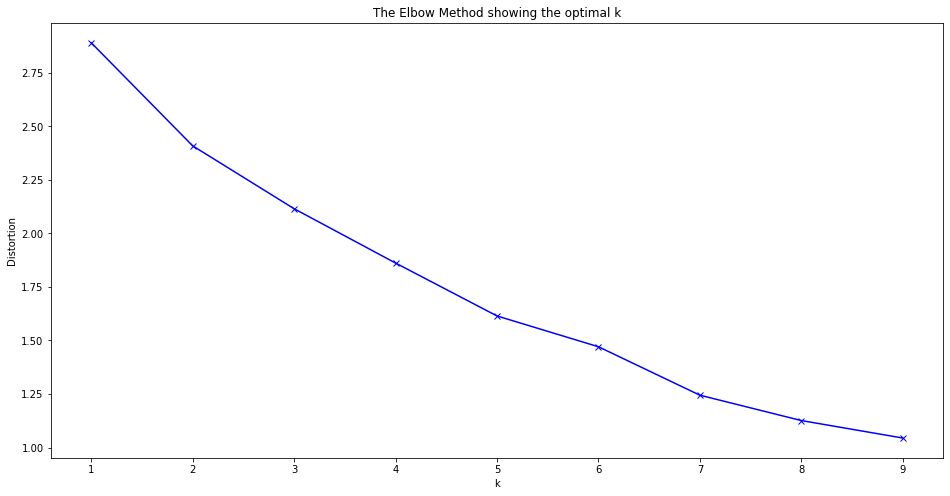

In [16]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

We could use seven clusters where the distortion has a lower curve, but for the size of the dataset, having so many clusters could difficult the analysis later in case of having to do a business study. 

That is why we finally will use five clusters, when the distortion curve is noticeably reduced and allows us to to analyze the clusters more clearly later.

In [17]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

### Merge the original dataframe with the grouped mean categories and the cluster assignations

To get a better visualization of the cluster result, we add the cluster labels to the neighborhoods_venues_sorted, and then we merge to this dataframe the first one with the latitude/longitude, borough and neighborhood.

In [18]:
# add clustering labels
toronto_grouped['Mean Sums'] = toronto_grouped.loc[:, toronto_grouped.columns != "Postal Code"].sum(1)
toronto_grouped.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged_means = df_toronto.join(toronto_grouped.set_index('Postal Code'), on='Postal Code')
toronto_merged_means.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Lawyer,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Post Office,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio,Mean Sums
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.021739,0.0,0.021739,0.0,0.0,0.021739,0.0000,0.0,0.0,0.065217,0.021739,0.000000,0.0,0.0,0.0,0.0,0.000000,0.021739,0.0000,0.0,0.0000,0.0,0.0,0.0000,0.0,0.0,0.043478,0.021739,0.00,0.0,0.00,0.000000,0.0,0.0,0.043478,0.0,0.0,0.0,0.0000,0.00,0.021739,0.0,0.0,0.000,0.0000,0.173913,0.0,0.000000,0.000000,0.0,0.00,0.0,0.0000,0.00,0.0,0.0,0.021739,0.0,0.000000,0.0,0.0,0.0,0.0,0.000,0.021739,0.0,0.000000,0.000000,0.021739,0.

## Create a map to visualize the clustering for every postal code

In [19]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11, tiles="Stamen Terrain")

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.autumn(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, postal, cluster in zip(toronto_merged_means['Latitude'], toronto_merged_means['Longitude'], toronto_merged_means['Postal Code'], toronto_merged_means['Cluster Labels']):
    label = folium.Popup(str(postal) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Explain the clusters

### Visualize clusters data

In [20]:
cluster_1 = toronto_merged_means[toronto_merged_means['Cluster Labels'] == 0]
cluster_2 = toronto_merged_means[toronto_merged_means['Cluster Labels'] == 1]
cluster_3 = toronto_merged_means[toronto_merged_means['Cluster Labels'] == 2]
cluster_4 = toronto_merged_means[toronto_merged_means['Cluster Labels'] == 3]
cluster_5 = toronto_merged_means[toronto_merged_means['Cluster Labels'] == 4]

In [21]:
cluster_1.loc[:, (cluster_1 != 0).any(axis=0)]

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Lawyer,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Post Office,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio,Mean Sums
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,0.021739,0.00,0.021739,0.000000,0.000000,0.021739,0.0000,0.000000,0.000000,0.065217,0.021739,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.021739,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.043478,0.021739,0.000000,0.000000,0.000000,0.000000,0.000000,0.043478,0.00,0.000000,0.000000,0.000000,0.000000,0.021739,0.000000,0.000000,0.000000,0.000000,0.173913,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.021739,0.000000,0.000000,0.000000,0.000000,

In [22]:
cluster_2.loc[:, (cluster_2 != 0).any(axis=0)]

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,Jewelry Store,Park,Playground,Sushi Restaurant,Trail,Mean Sums
21,M5P,Central Toronto,"Forest Hill North & West, Forest Hill Road Park",43.696948,-79.411307,1,0.25,0.25,0.00,0.25,0.25,1.0
33,M4W,Downtown Toronto,Rosedale,43.679563,-79.377529,1,0.00,0.50,0.25,0.00,0.25,1.0


In [23]:
cluster_3.loc[:, (cluster_3 != 0).any(axis=0)]

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,Board Shop,Breakfast Spot,Brewery,Burrito Place,Bus Line,Butcher,Coffee Shop,Comic Shop,Dance Studio,Department Store,Dim Sum Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Food & Drink Shop,Garden,Garden Center,Gym,Gym / Fitness Center,Hotel,Ice Cream Shop,Italian Restaurant,Light Rail Station,Liquor Store,Movie Theater,Park,Pet Store,Pizza Place,Pub,Restaurant,Sandwich Place,Skate Park,Steakhouse,Sushi Restaurant,Swim School,Mean Sums
15,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572,2,0.047619,0.000000,0.047619,0.000000,0.00,0.000000,0.047619,0.000000,0.000000,0.000000,0.00,0.000000,0.095238,0.047619,0.047619,0.000000,0.000000,0.047619,0.000000,0.000000,0.047619,0.047619,0.000000,0.047619,0.047619,0.095238,0.047619,0.047619,0.047619,0.047619,0.047619,0.000000,0.047619,0.047619,0.00,1.0
18,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,2,0.000000,0.000000,0.000000,0.000000,0.25,0.000000,0.000000,0.000000,0.000000,0.000000,0.25,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.25,1.0
20,M4P,Central Toronto,Davisville North,43.712751,-79.390197,2,0.000000,0.111111,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.111111,0.111111,0.00,0.000000,0.000000,0.000000,0.111111,0.000000,0.000000,0.111111,0.111111,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000,0.00,1.0
38,M7Y,East Toronto,"Business reply mail Processing Centre, South C...",43.662744,-79.321558,2,0.000000,0.000000,0.066667,0.066667,0.00,0.066667,0.000000,0.066667,0.000000,0.000000,0.00,0.066667,0.066667,0.000000,0.000000,0.066667,0.066667,0.000000,0.066667,0.000000,0.000000,0.000000,0.133333,0.000000,0.000000,0.066667,0.000000,0.066667,0.000000,0.066667,0.000000,0.066667,0.000000,0.000000,0.00,1.0


In [24]:
cluster_4.loc[:, (cluster_4 != 0).any(axis=0)]

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,Fast Food Restaurant,Garden,Health & Beauty Service,Mean Sums
19,M5N,Central Toronto,Roselawn,43.711695,-79.416936,3,0.333333,0.333333,0.333333,1.0


In [25]:
cluster_5.loc[:, (cluster_5 != 0).any(axis=0)]

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,Health Food Store,Neighborhood,Pub,Trail,Mean Sums
4,M4E,East Toronto,The Beaches,43.676357,-79.293031,4,0.25,0.25,0.25,0.25,1.0


## Conclusion 

After having selected the boroughs that contains <i>Toronto</i>, having cleaned the data and having added the businesses that exist in each zone according to their zip code, we made 5 clusters of the dataset distributed by the number of businesses in the different neighborhoods.


We can identify:

- <b>In the first cluster</b> we observe the largest number of zip code areas. These areas are the ones with the highest volume of business with a very wide variety.

- <b>In the second cluster</b> less variety of businesses are observed. It is also observed that in both zip code zones we find <i>parks</i>.

- <b>In the third cluster</b> there are fewer businesses compared to the previous clusters, but it has a large variety of them.

- <b>In the fourth cluster</b> There is only one area with 3 business categories.

- <b>In the fifth cluster</b> we find a low volume of business as in the fourth cluster, but with different categories.

By visualizing the clusters and their results, as a business owner or stakeholders, they can assess whether they prefer to open a new business:

* in areas of the first or third cluster, where there seems to be more crowded but there is a greater variety of businesses,


* or do it in areas of the fourth or fifth cluster, where there is a lower volume of business and greater possibility of opening a business that does not exist in the area.